# Finding the top 10 brands + Calculating Lift

## Set up

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [8, 8]

#hide all warnings
import warnings
warnings.filterwarnings('ignore')

### Directories

In [2]:
data_dir = "../data/"
plots_dir = "../plots/"

## Raw Data

### Comments

In [3]:
raw_comments = pd.read_csv(data_dir+"CARS_ALL_COMMENTS.csv")
raw_comments.head()

,User_Name,Date,Review_Text
0,pat,2007-04-11T17:09:38+00:00,We know that the midsize sedans topic has been...
1,motownusa,2007-04-12T02:52:38+00:00,Hi Pat:You forgot the Chrysler Sebring \n0
2,exshoman,2007-04-12T03:33:49+00:00,I'm sure some folks would appreciate having th...
3,targettuning,2007-04-12T14:51:22+00:00,You can try to revive this topic but without b...
4,pat,2007-04-12T16:43:51+00:00,Model vs. model is exactly what we're here for...


### Model-to-brand Mapping

In [4]:
raw_model_map = pd.read_csv(data_dir+"Car_Model_List.csv")
raw_model_map.head()

,model,brand
0,integra,acura
1,legend,acura
2,vigor,acura
3,rlx,acura
4,ilx,acura


## Data Preprocssing

### Model-to-brand Mapping

In [5]:
model_map = raw_model_map.copy()
# Clean data
# Remove problematic entries
rem_dict = {
    "brand": ["car", "sedan", "problem"],
    "model": ["is", "i", "2", "m", "seats"]
}

for key in rem_dict.keys():
    for val in rem_dict[key]:
        model_map = model_map[model_map[key]!=val]

model_map.reset_index(inplace=True, drop=True)

# Replace missing models
add_dict = {
    "lexus": ["is300","is500", "is350"],
    "infiniti": ["g25", "m25", "m37", "m56", "m35h", "m30d", "m30"],
    "polestar": ["polestar"],
    "seat": ['alhambra', 'ateca', 'toledo', 'leon', 'st', 'x-perience', 'mii',
       'tarraco', 'ibiza', 'arona', 'ronda', 'cordoba', 'cupra', 'fura',
       'arosa', 'exeo', 'marblla', 'malaga', 'formula', 'tango', 'ibe',
       'bocanegra', 'bolero', 'salsa', 'altea', 'tribu', 'madrid',
       'proto', 'inca']
}

for brand in add_dict.keys():
    for model in add_dict[brand]:
        model_map.loc[len(model_map.index)]=[model, brand]

In [6]:
model_map.to_csv(data_dir+'clean_model_map.csv')

### Comments

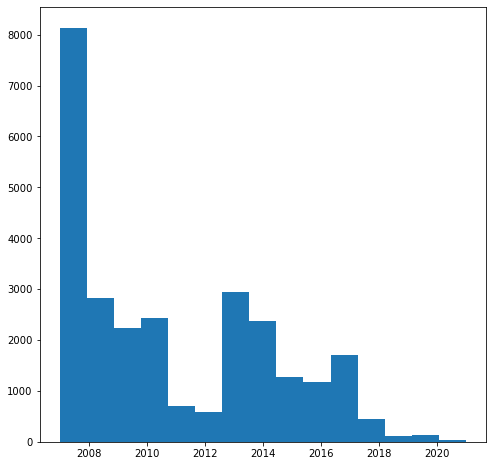

In [7]:
comments = raw_comments.copy()

# Simplify column indexing
comments.columns = comments.columns.str.lower()

# Plot activiy timeline
comments.date = pd.to_datetime(comments.date)
comments['year'] = comments.date.dt.year
plt.hist(comments.year, bins=len(comments.year.unique()))
plt.show()

# Export selected records
comments.to_csv(data_dir+'CARS_2013-2016.csv')

In [8]:
# Focus on time period of interest
comments = comments[(comments.year<=2016) & (comments.year>=2013)]
comments.shape

(7782, 4)

In [9]:
# Ignore case when comparing tokens
comments.review_text = comments.review_text.str.lower()

# Replace all model names with associated brand (Ignores misspelled models)
for model, brand in model_map.itertuples(index=False):
    model = r'\W'+model+'\W' # regex for model name
    brand = ' '+brand+' '
    comments.review_text = comments.review_text.str.replace(model, brand, regex=True)

In [10]:
comments.to_csv(data_dir+'branded_comments.csv')
comments.head()

,user_name,date,review_text,year
16928,cannon3,2013-01-01 01:01:25+00:00,curious to see how toyota sales are going to b...,2013
16929,[Deleted User],2013-01-01 01:34:33+00:00,i don't think there is any way that the ford c...,2013
16930,ajr1775,2013-01-02 00:27:03+00:00,the car is as advertised. picked it up last ni...,2013
16931,stickguy,2013-01-02 00:57:32+00:00,sounds like a good deal. i just described it t...,2013
16932,ajr1775,2013-01-02 01:20:09+00:00,that rate i got was based on 12k miles per yea...,2013


## Counting Brand Occurances

In [11]:
# Count number of comments that mention each brand
brands = model_map.brand.unique()
brand_bin = []
for brand in brands:
    brand = r'\W'+brand+'\W'
    brand_bin.append(comments.review_text.str.contains(brand))

In [12]:
occ_brand = pd.DataFrame(np.array(brand_bin).transpose(), columns=brands)
occ_brand.head()

,acura,audi,bmw,buick,cadillac,chevrolet,chrysler,dodge,ford,honda,...,panoz,oldsmobile,daewoo,plymouth,eagle,geo,daihatsu,rivian,polestar,seat
0,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Top 10 Brands

In [13]:
top_brands = occ_brand.sum().nlargest(n=10)
top_brands.to_csv(data_dir+'top_10_brands.csv')
top_brands = top_brands.index

### Cooccurance Matrix

In [14]:
co_matrix = pd.DataFrame(index=top_brands, columns=top_brands)
for i in top_brands:
    for j in top_brands:
        co_matrix[i][j] = occ_brand[i].multiply(occ_brand[j]).sum()

co_matrix

,honda,ford,infiniti,kia,toyota,acura,hyundai,mazda,chevrolet,volkswagen
honda,2833,841,1207,650,982,976,612,661,473,450
ford,841,2342,518,477,575,707,455,399,305,270
infiniti,1207,518,2114,1266,430,807,399,386,222,264
kia,650,477,1266,1724,404,210,524,395,277,242
toyota,982,575,430,404,1503,316,430,351,312,243
acura,976,707,807,210,316,1437,242,227,127,236
hyundai,612,455,399,524,430,242,1241,298,276,261
mazda,661,399,386,395,351,227,298,1136,218,228
chevrolet,473,305,222,277,312,127,276,218,1046,195
volkswagen,450,270,264,242,243,236,261,228,195,810


In [15]:
# Export matrix as csv
co_matrix.to_csv(data_dir+"co_matrix.csv")

### Calculating Lift Values

In [16]:
co_matrix = pd.read_csv(data_dir+"co_matrix.csv")
co_matrix.set_index("Unnamed: 0", inplace=True)
co_matrix

,honda,ford,infiniti,kia,toyota,acura,hyundai,mazda,chevrolet,volkswagen
Unnamed: 0,,,,,,,,,,
honda,2833,841,1207,650,982,976,612,661,473,450
ford,841,2342,518,477,575,707,455,399,305,270
infiniti,1207,518,2114,1266,430,807,399,386,222,264
kia,650,477,1266,1724,404,210,524,395,277,242
toyota,982,575,430,404,1503,316,430,351,312,243
acura,976,707,807,210,316,1437,242,227,127,236
hyundai,612,455,399,524,430,242,1241,298,276,261
mazda,661,399,386,395,351,227,298,1136,218,228
chevrolet,473,305,222,277,312,127,276,218,1046,195


In [17]:
lift_matrix = co_matrix.copy()
N = comments.shape[0] #number of comments 
for i in range(10):
    for j in range(10):
        if i==j:
            lift_matrix.iloc[i,j]=1
        else:
            lift_matrix.iloc[i,j] = round(N * (co_matrix.iloc[i,j]/(co_matrix.iloc[i,i]*co_matrix.iloc[j,j])),2)
lift_matrix.to_csv(data_dir+"lift_matrix.csv")

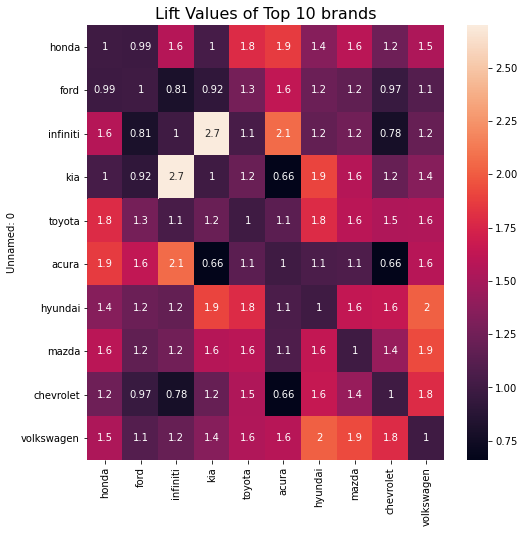

In [18]:
sns.heatmap(lift_matrix, annot=True)
plt.title('Lift Values of Top 10 brands', fontsize=16);

In [19]:
# MDS Plot
dissimilarity = 1/lift_matrix
np.fill_diagonal(dissimilarity.values, 0)
dissimilarity

,honda,ford,infiniti,kia,toyota,acura,hyundai,mazda,chevrolet,volkswagen
Unnamed: 0,,,,,,,,,,
honda,0.000000,1.010101,0.636943,0.961538,0.558659,0.534759,0.740741,0.625000,0.806452,0.653595
ford,1.010101,0.000000,1.234568,1.086957,0.787402,0.613497,0.819672,0.854701,1.030928,0.900901
infiniti,0.636943,1.234568,0.000000,0.370370,0.952381,0.483092,0.847458,0.800000,1.282051,0.833333
kia,0.961538,1.086957,0.370370,0.000000,0.826446,1.515152,0.523560,0.636943,0.833333,0.740741
toyota,0.558659,0.787402,0.952381,0.826446,0.000000,0.877193,0.558659,0.625000,0.649351,0.645161
acura,0.534759,0.613497,0.483092,1.515152,0.877193,0.000000,0.943396,0.925926,1.515152,0.632911
hyundai,0.740741,0.819672,0.847458,0.523560,0.558659,0.943396,0.000000,0.609756,0.606061,0.495050
mazda,0.625000,0.854701,0.800000,0.636943,0.625000,0.925926,0.609756,0.000000,0.699301,0.518135
chevrolet,0.806452,1.030928,1.282051,0.833333,0.649351,1.515152,0.606061,0.699301,0.000000,0.558659


In [20]:
from sklearn.manifold import MDS

#calculating MDS values
mds_values=MDS(n_components=2, dissimilarity ='precomputed', random_state=0)
results=mds_values.fit_transform(dissimilarity)

x,y = results.T

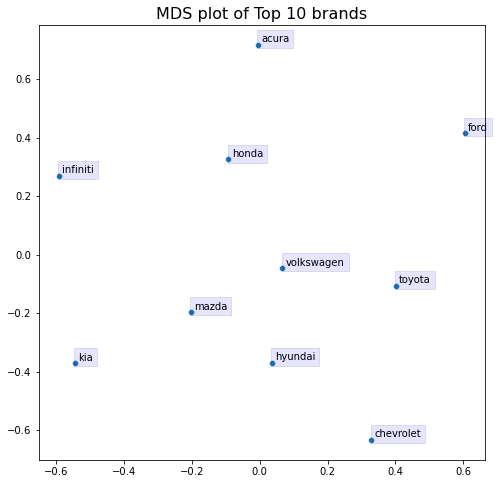

In [21]:
#plotting MDS graph

sns.scatterplot(x,y)

for i,brand in enumerate(dissimilarity.columns.values):
  plt.text(s=brand, x= x[i] + 0.01, y=y[i]+0.01, bbox=dict(facecolor="blue",alpha=0.1))
plt.title('MDS plot of Top 10 brands', fontsize=16)
plt.savefig(plots_dir+'MDSplot.png')
plt.show();